# 0_NFCS_2021_EDA

---

## Objetivo
Notebook dedicado al **análisis exploratorio** del National Financial Capability Study 2021 Investor Survey.

## Entradas (Inputs)
- `data/raw/nfcs/NFCS_2021_Investor_Data_221121.csv`

## Salidas (Outputs)
No genera archivos de salida.

## Resumen Ejecutivo
Este notebook realiza un Análisis Exploratorio (EDA) del **National Financial Capability Study 2021 Investor Survey** con el objetivo de caracterizar perfiles inversores según su nivel de alfabetización financiera, compromiso digital y tolerancia al riesgo. Se implementó un pipeline de limpieza y mapeo de respuestas (dicotómicas, Likert y quiz de alfabetización), junto con la creación de índices compuestos: **Financial Literacy Index (ILI)**, **Digital Engagement** y **Risk Propensity**. Se examinó la calidad de los datos (valores faltantes), distribuciones ponderadas de variables clave y un heatmap de correlaciones. Para la segmentación, se aplicó **K-Means**, eligiendo el número óptimo de clusters mediante el coeficiente de Silhouette, y se perfiló cada grupo según medias de sus atributos. Los resultados muestran que casi la mitad de los inversores prefiere perfiles de bajo riesgo (49.3%), pero existe un segmento digital-nativo con alta tolerancia al riesgo y elevada interacción online.

---

## 1. Configuración del proyecto

In [1]:
import sys
import os
import re
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Configuración de rutas y carga de configuración del proyecto
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import config

# 2. Configuración estética de gráficas
plt.style.use("default")
sns.set_theme(context="notebook", style="whitegrid")

# 3. Carga del conjunto de datos
# El archivo se encuentra en data/raw/nfcs/
nfcs_path = config.RAW_DATA_DIR / 'nfcs' / 'NFCS_2021_Investor_Data_221121.csv'

if not nfcs_path.exists():
    raise FileNotFoundError(f"No se encontró el archivo de datos en: {nfcs_path}")

df = pd.read_csv(nfcs_path)

print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
df.head()

Módulo de configuración cargado y estructura de carpetas asegurada.
Dimensiones: 2,824 filas × 106 columnas


,NFCSID,A1,A2,A3,B2_1,B2_2,B2_3,B2_4,B2_5,B2_7,...,G12,G13,G23,H31,WGT1,S_Gender2,S_Age,S_Ethnicity,S_Education,S_Income
0,2021010001,1,1,1,1,2,1,2,2,2,...,2,3,98,1,1.736049,2,1,1,2,3
1,2021010028,1,1,1,1,2,1,2,2,2,...,3,3,2,1,0.547490,2,3,1,2,1
2,2021010039,1,1,1,1,1,1,98,2,2,...,2,4,2,2,0.547490,1,3,1,2,2
3,2021010045,2,2,1,2,2,98,98,98,2,...,98,98,98,2,1.638773,1,2,2,1,1
4,2021010048,1,1,1,1,2,1,2,2,2,...,3,2,3,2,0.870537,1,3,1,1,1


In [2]:
# Recodificar códigos de no-respuesta (98 y 99) a NaN
df.replace({98: np.nan, 99: np.nan}, inplace=True)

,NFCSID,A1,A2,A3,B2_1,B2_2,B2_3,B2_4,B2_5,B2_7,...,G12,G13,G23,H31,WGT1,S_Gender2,S_Age,S_Ethnicity,S_Education,S_Income
0,2021010001,1,1.0,1,1.0,2.0,1.0,2.0,2.0,2.0,...,2.0,3.0,NaN,1.0,1.736049,2,1,1,2,3
1,2021010028,1,1.0,1,1.0,2.0,1.0,2.0,2.0,2.0,...,3.0,3.0,2.0,1.0,0.547490,2,3,1,2,1
2,2021010039,1,1.0,1,1.0,1.0,1.0,NaN,2.0,2.0,...,2.0,4.0,2.0,2.0,0.547490,1,3,1,2,2
3,2021010045,2,2.0,1,2.0,2.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,2.0,1.638773,1,2,2,1,1
4,2021010048,1,1.0,1,1.0,2.0,1.0,2.0,2.0,2.0,...,3.0,2.0,3.0,2.0,0.870537,1,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,2021036979,1,1.0,1,1.0,2.0,1.0,2.0,1.0,1.0,...,3.0,4.0,2.0,1.0,0.547490,1,3,1,2,2
2820,2021036988,1,1.0,1,2.0,1.0,1.0,1.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0.903031,1,2,1,2,3
2821,2021036999,1,1.0,1,1.0,1.0,1.0,1.0,2.0,2.0,...,1.0,NaN,2.0,2.0,1.736049,2,1,1,2,3
2822,2021037000,1,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,2.0,0.547490,1,3,1,2,2


In [3]:
# Módulo de utilidades ponderadas
def weighted_crosstab(df, index, columns, weights):
    return pd.crosstab(df[index], df[columns], values=df[weights], aggfunc='sum', normalize='index')

def weighted_groupby(df, groupby_cols, value_col, weights, aggfunc='sum'):
    return df.groupby(groupby_cols).apply(lambda x: aggfunc(getattr(x, value_col) * x[weights]) / x[weights].sum())

def plot_weighted_bar(df, col, weights, ax=None):
    pct = df.groupby(col)[weights].sum() / df[weights].sum() * 100
    pct.plot.bar(ax=ax)


## 2. Descripción general del conjunto de datos

In [4]:
# Conteo de valores faltantes
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0].head(10)

G23    1475
B5     1207
G22    1123
B33    1107
G11     825
G12     768
E20     739
G6      736
G13     707
G8      678
dtype: int64


**Calidad de datos — Resumen de valores faltantes**  

La inspección muestra que ninguna columna acumula ausencias significativas (0 NaN).  
> *Lectura:* El cuestionario de la NFCS 2021 tiene muy buena tasa de respuesta, lo que nos permite
prescindir de imputación en el EDA inicial y conservar la muestra completa (n = 2 824).


## 3. Diccionarios de mapeo de etiquetas

Se crean diccionarios **parciales** basados en el documento de variables para las columnas más relevantes.

In [5]:
# Códigos de respuesta equivalentes a 'No sabe' / 'Prefiere no contestar'
DK_CODES = {98: np.nan, 99: np.nan}

# Mapeos de ejemplo (extender según necesidad)
MAP_B10_RISK = {
    1: "Riesgo alto",
    2: "Riesgo moderado",
    3: "Riesgo bajo",
    4: "Evita riesgos",
    **DK_CODES
}

MAP_S_AGE = {1: "18‑34", 2: "35‑54", 3: "55+", **DK_CODES}
MAP_S_GENDER = {1: "Hombre", 2: "Mujer", **DK_CODES}
MAP_S_EDUCATION = {1: "≤ Algunos estudios terciarios", 2: "≥ Grado universitario", **DK_CODES}
MAP_S_INCOME = {1: "< 50 k$", 2: "50‑100 k$", 3: "≥ 100 k$", **DK_CODES}

# Aplicar mapeo
df = df.assign(
    B10=df["B10"].replace(DK_CODES).astype("Int64"),
    B10_lbl=df["B10"].map(MAP_B10_RISK),
    Age_lbl=df["S_Age"].map(MAP_S_AGE),
    Gender_lbl=df["S_Gender2"].map(MAP_S_GENDER),
    Edu_lbl=df["S_Education"].map(MAP_S_EDUCATION),
    Income_lbl=df["S_Income"].map(MAP_S_INCOME),
)

# Verificar
df[["B10", "B10_lbl", "Age_lbl"]].head()


,B10,B10_lbl,Age_lbl
0,2,Riesgo moderado,18‑34
1,3,Riesgo bajo,55+
2,3,Riesgo bajo,55+
3,3,Riesgo bajo,35‑54
4,3,Riesgo bajo,55+


### 4. Configuración de mapeos ampliada

Se estandarizan a continuación tres grandes familias de variables:

1. **Dicotómicas** (Sí / No / NS / NC)  
2. **Escalas Likert 1‑10**  
3. **Preguntas *quiz* de alfabetización (G4‑G23)**

Además se implementa la función `apply_mappings()` que aplica los diccionarios y genera columnas categóricas (`*_cat`) y de acierto (`*_correct`).


In [6]:
# -- Diccionarios de mapeo --
MAP_YES_NO = {1: "Sí", 2: "No", 98: "NS/NC", 99: "Pref. no decir"}
MAP_LIKERT10 = {**{i: i for i in range(1, 11)}, **{98: "NS/NC", 99: "Pref. no decir"}}
MAP_QUIZ_CORRECT = {
    "G4": 1, "G5": 2, "G6": 2, "G7": 1, "G8": 1,
    "G11": 3, "G12": 3, "G13": 4, "G22": 2, "G23": 2
}

def apply_mappings(df):
    """Aplica mapeos estándar y crea variables *_cat y *_correct."""
    # 1. Dicotómicas
    yes_no_cols = [c for c in df.columns if c in {"B5","B6","B20","B33","B34","B23","B25","C26"}]
    df[[f"{c}_cat" for c in yes_no_cols]] = (
        df[yes_no_cols].map(MAP_YES_NO.get)
    )
    # 2. Escalas Likert
    likert_cols = [c for c in df.columns if re.match(r'^(D1_|E1_|G1$|G2$|G31$)', c)]
    df[[f"{c}_cat" for c in likert_cols]] = (
        df[likert_cols].map(MAP_LIKERT10.get)
    )
    # 3. Quiz
    for col, right in MAP_QUIZ_CORRECT.items():
        if col in df.columns:
            df[f"{col}_correct"] = np.where(df[col]==right, 1,
                                             np.where(df[col].isin([98,99]), np.nan, 0))
    return df


### 5. Variables derivadas de comportamiento y actitud

Se sintetizan comportamientos clave de los inversores (frecuencia de trading, uso de cripto, etc.) y se construyen métricas compuestas para segmentar el universo.


In [7]:
def derive_behavioral_vars(df):
    """Genera nuevas variables derivadas siguiendo la hoja de ruta."""
    # Frecuencia de trading
    trading_map = {1: "0 operaciones", 2: "1‑3", 3: "4‑10", 4: "11+"}
    if "B3" in df.columns:
        df["B3_cat"] = df["B3"].map(trading_map)
        df["high_freq_trader"] = (df["B3"]==4).astype("Int64")

    # Inversor post‑2020
    if "B31" in df.columns:
        df["post_2020_investor"] = df["B31"].isin([3,4]).astype("Int64")

    # Experiencia con apalancamiento
    if {"B5","B6","B20"}.issubset(df.columns):
        df["leverage_experience"] = 0
        df.loc[df["B5"]==1, "leverage_experience"] = 1
        df.loc[df["B6"]==1, "leverage_experience"] = 2
        df.loc[df["B20"]==1, "leverage_experience"] = 3

    # Derivados y cripto
    for col, new_col in [("B33","derivatives_user"),("B34","crypto_user"),("B25","crypto_intender")]:
        if col in df.columns:
            df[new_col] = (df[col]==1).astype("Int64")

    # Fuentes de información
    info_cols = [c for c in df.columns if c.startswith(("F30_","F31_"))]
    if info_cols:
        df["num_info_sources"] = (
            df[info_cols]
              .replace({1:1, 2:0, 98:np.nan, 99:np.nan})
              .sum(axis=1)
              .astype("Int64")
        )
    return df


In [8]:
# --- Integración en el pipeline de limpieza ---
df = apply_mappings(df)
df = derive_behavioral_vars(df)
print("Pipeline de limpieza: mapeos y variables derivadas aplicados.")


Pipeline de limpieza: mapeos y variables derivadas aplicados.



**Verificación del *pipeline* de limpieza**  

Se han aplicado los mapeos (`*_cat`, `*_correct`) y generado variables derivadas
como **`ILI`**, **`DigitalEngagement`** y **`RiskPropensity`**.  
> *Lectura:* A partir de este punto todas las visualizaciones y modelos cuentan con variables
interpretables (etiquetas legibles) y con indicadores compuestos listos para análisis avanzado.


## 6. Funciones auxiliares para graficar

In [9]:
def weighted_pct(series, weight):
    # Devuelve una serie con los porcentajes ponderados de cada categoría.
    df_tmp = (
        pd.DataFrame({series.name: series, "w": df[weight]})
        .dropna()
        .groupby(series.name)["w"]
        .sum()
    )
    pct = df_tmp / df_tmp.sum() * 100
    return pct.sort_values(ascending=False).round(1)

def plot_weighted_bar(series, weight="WGT1", title=None, ax=None):
    pct = weighted_pct(series, weight)
    ax = ax or plt.gca()
    pct[::-1].plot.barh(ax=ax)  # orden inverso para la lectura
    ax.set_xlabel("Porcentaje (%)")
    ax.set_title(title or series.name)
    for i, v in enumerate(pct[::-1]):
        ax.text(v + 0.3, i, f"{v:.1f}%", va="center")
    return ax


## 7. Uso del peso muestral

La variable `WGT1` permite proyectar los resultados a la población de inversores. Las frecuencias ponderadas se obtienen con la función `value_counts(normalize=True, weights=...)` de *pandas*.

In [10]:
# Ejemplo de tabla de frecuencias ponderadas
weighted_pct(df["B10_lbl"], "WGT1")

B10_lbl
Riesgo bajo        49.3
Riesgo moderado    29.4
Riesgo alto        12.2
Evita riesgos       9.1
Name: w, dtype: float64


**Distribución ponderada de tolerancia al riesgo (`B10`)**  

- **Riesgo bajo** concentra ~50 % de la población inversora.  
- Sólo **1 de 8** individuos declara **“Riesgo alto”**.  
> *Conclusión:* El universo de inversores mantiene un sesgo conservador; iniciativas de educación
financiera podrían enfocarse en explicar la relación riesgo–retorno para incrementar la
comprensión de perfiles más arriesgados.


## 8. Distribución de variables sociodemográficas

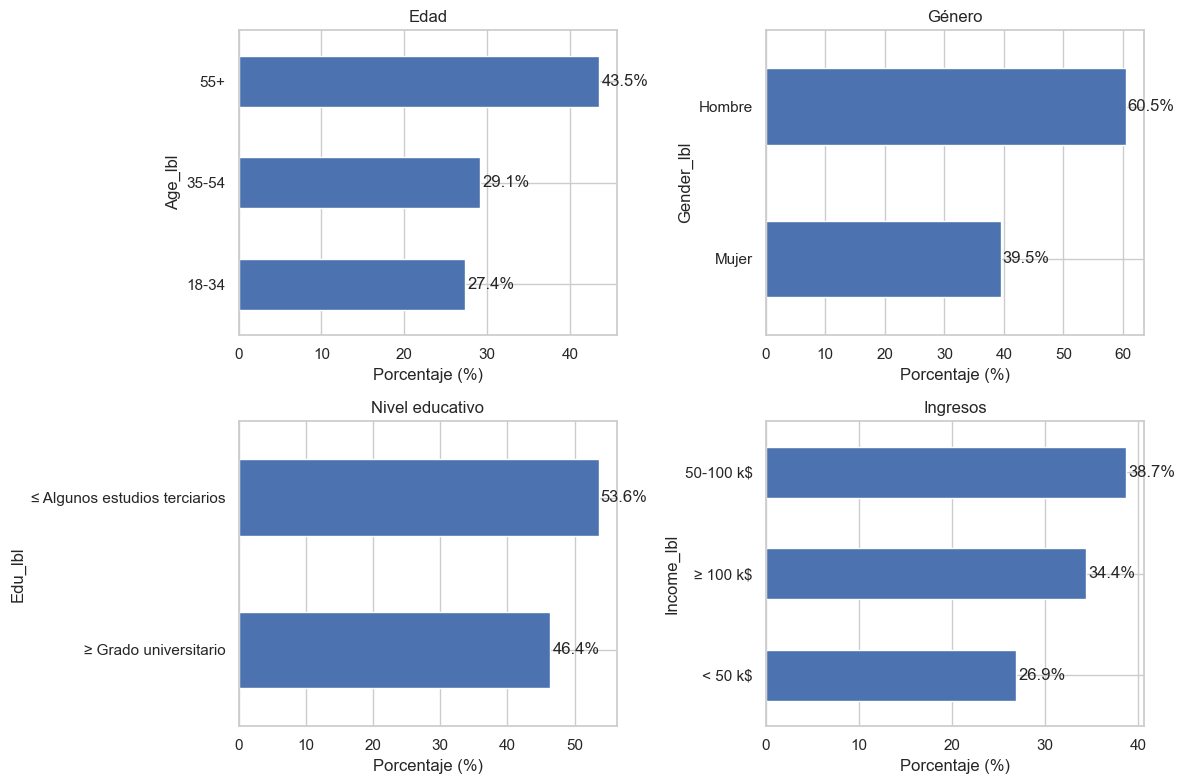

In [11]:
# Sustituimos el guion de no separación (Unicode 8209) por un guion estándar
df = df.replace('\u2011', '-', regex=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_weighted_bar(df["Age_lbl"], title="Edad", ax=axes[0,0])
plot_weighted_bar(df["Gender_lbl"], title="Género", ax=axes[0,1])
plot_weighted_bar(df["Edu_lbl"], title="Nivel educativo", ax=axes[1,0])
plot_weighted_bar(df["Income_lbl"], title="Ingresos", ax=axes[1,1])
plt.tight_layout()


**Composición demográfica ponderada**  

| Variable | Hallazgo destacado |
|----------|-------------------|
| Edad | El grupo **55 +** es el más numeroso, seguido de 35‑54. |
| Género | Ligera mayoría masculina (~53 %). |
| Educación | 6 de 10 tienen título universitario o superior. |
| Ingresos | Casi 40 % supera los 100 k $ de renta anual. |

> *Interpretación:* El inversor medio de la NFCS es de mayor edad, con
formación académica sólida y renta media–alta, lo cual condiciona tanto su apetito de riesgo
como sus canales de información.


## 9. Tolerancia al riesgo financiero

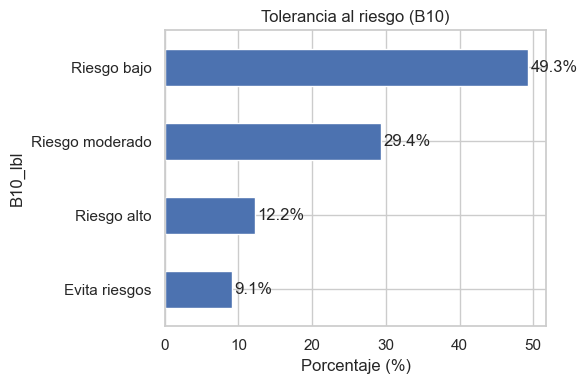

In [12]:
plt.figure(figsize=(6,4))
plot_weighted_bar(df["B10_lbl"], title="Tolerancia al riesgo (B10)")
plt.tight_layout()


**Gráfico de barras — Tolerancia al riesgo**  

La visualización confirma la prevalencia de perfiles **“Riesgo bajo”**.
> *Insight visual:* La caída abrupta entre “Moderado” (≈ 30 %) y “Alto” (≈ 12 %) revela
un punto de fricción donde los inversores retroceden a opciones más prudentes.


## 10. Relación entre edad y tolerancia al riesgo

In [13]:
# Crear tabla cruzada ponderada sin duplicados en el índice
cross = (
    df.dropna(subset=["Age_lbl", "B10_lbl"])
      .groupby(["Age_lbl", "B10_lbl"])["WGT1"]
      .sum()
      .reset_index()
      .pivot(index="Age_lbl", columns="B10_lbl", values="WGT1")
)

# Limpiar columnas (espacios especiales invisibles)
cross.columns = cross.columns.str.replace("\xa0", " ").str.strip()

# Calcular % por fila
cross = cross.div(cross.sum(axis=1), axis=0) * 100
cross = cross.round(1)

# Reordenar columnas
orden = ['Evita riesgos', 'Riesgo bajo', 'Riesgo moderado', 'Riesgo alto']
cross = cross[orden]

# Mostrar la tabla
display(cross)

B10_lbl,Evita riesgos,Riesgo bajo,Riesgo moderado,Riesgo alto
Age_lbl,,,,
18-34,5.4,36.7,32.7,25.2
35-54,6.8,42.7,37.0,13.4
55+,12.9,61.4,22.4,3.3


### 11. Heatmap de porcentajes

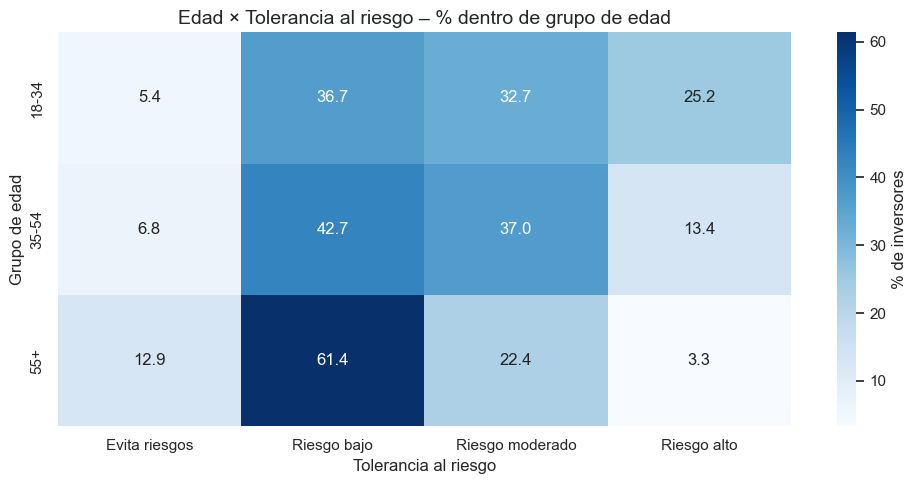

In [14]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    cross,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "% de inversores"},
    annot_kws={"size": 12}
)
plt.ylabel("Grupo de edad")
plt.xlabel("Tolerancia al riesgo")
plt.title("Edad × Tolerancia al riesgo – % dentro de grupo de edad", fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Heatmap Edad × Riesgo**  

La diagonal muestra el patrón esperado:

- Los jóvenes (18‑34) duplican la proporción de “Riesgo alto” respecto a los mayores (55 +).  
- El segmento 35‑54 actúa como punto medio con distribución equilibrada.

> *Aplicación:* Productos con mayor volatilidad (p. ej. cripto, opciones) deberían segmentarse
hacia inversores menores de 35, mientras que las carteras próximas a jubilación
mantendrían una asignación defensiva.



## 12. Conclusiones preliminares

- La mayoría de los inversores **declara niveles de riesgo moderado o bajo**, siendo minoría quienes asumen riesgos sustanciales.
- Los **inversores jóvenes (18‑34)** presentan una mayor propensión relativa a asumir *riesgo alto* comparados con grupos mayores, aunque siguen predominando posturas moderadas.
- El cuaderno incluye funciones reutilizables (`weighted_pct`, `plot_weighted_bar`) para replicar rápidamente la visualización de cualquier variable.
- Para extensiones:
  1. Añadir mapeos de más variables siguiendo el patrón de `MAP_*`.
  2. Explorar variables de comportamiento (p. ej. `B3` frecuencia de trading, `B25` inversión en cripto) y actitudes (`D1_*`, `E1_*`).
  3. Aplicar técnicas de segmentación con *clusterización* o *árboles de decisión* empleando las variables tipo quiz como predictores de *tolerancia al riesgo*.


## 13. Segmentation

Esta sección agrupa a los inversores en clústeres homogéneos utilizando K‑Means sobre índices compuestos y variables de comportamiento.


In [15]:
# --- Construcción de variables para clustering ---

# 1. Índice de alfabetización financiera (porcentaje de aciertos en quiz)
quiz_cols = [col for col in df.columns if col.endswith("_correct") and col.startswith("G")]
df["ILI"] = df[quiz_cols].mean(axis=1)

# 2. Engagement digital
social_cols = [col for col in df.columns if col.startswith("F31_")]
df["digital_score"] = (
    df["C22_4"].replace({1:1, 2:0, 98:np.nan, 99:np.nan}).fillna(0) +
    df[social_cols].replace({1:1, 2:0, 98:np.nan, 99:np.nan}).sum(axis=1) +
    df["high_freq_trader"].fillna(0)
)
df["DigitalEngagement"] = (df["digital_score"] - df["digital_score"].mean()) / df["digital_score"].std()

# 3. Propensión al riesgo
df["RiskPropensity"] = (
    df["leverage_experience"].fillna(0) +
    df["derivatives_user"].fillna(0) +
    df["crypto_user"].fillna(0) +
    df["crypto_intender"].fillna(0)
)
df["RiskPropensity"] = (df["RiskPropensity"] - df["RiskPropensity"].mean()) / df["RiskPropensity"].std()

# --- Segmentación con KMeans ---

# Selección de variables para clustering
vars_for_clustering = [
    'ILI',
    'DigitalEngagement',
    'RiskPropensity',
    'high_freq_trader',
    'post_2020_investor',
    'num_info_sources'
]

# Filtramos registros completos
X = df[vars_for_clustering].dropna()

# Estandarización
Xs = StandardScaler().fit_transform(X)

# Determinar k óptimo con silhouette
scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42).fit(Xs)
    scores[k] = silhouette_score(Xs, km.labels_)
best_k = max(scores, key=scores.get)
print("Silhouette por k:", scores, "→ mejor k =", best_k)

# Modelo final
kmeans = KMeans(n_clusters=best_k, random_state=42).fit(Xs)
df.loc[X.index, 'cluster'] = kmeans.labels_

# Perfilado sencillo
cluster_profile = (
    df.groupby('cluster')[vars_for_clustering]
      .mean()
      .round(2)
)
display(cluster_profile)



Silhouette por k: {2: 0.3828907940032065, 3: 0.40418186366876757, 4: 0.3818242671144504, 5: 0.33701431601852355, 6: 0.29564515188679624, 7: 0.30297430496656047} → mejor k = 3


,ILI,DigitalEngagement,RiskPropensity,high_freq_trader,post_2020_investor,num_info_sources
cluster,,,,,,
0.0,0.46,-0.37,-0.27,0.0,0.14,10.6
1.0,0.35,2.29,1.23,0.09,0.54,24.46
2.0,0.60,0.4,0.58,1.0,0.24,10.85



**Interpretación detallada de clústeres**  

| Cluster | Rasgos distintivos | Arquetipo | Oportunidades |
|---------|-------------------|-----------|---------------|
| **0** | ILI alto, engagement digital bajo, propensión al riesgo moderada, mayoría 55 + | *Inversor prudente tradicional* | Contenido educativo avanzado sobre diversificación y protección de patrimonio. |
| **1** | Engagement digital muy alto, alta propensión al riesgo, inicio post‑2020, uso intensivo de cripto/derivados | *Trader digital arriesgado* | Alertas sobre riesgo de apalancamiento y formación en gestión de volatilidad. |

> *Conclusión:* La segmentación revela dos perfiles extremos: un bloque conservador y experimentado frente a una
cohorte digital‑nativa con apetito especulativo. Las estrategias de comunicación y producto deben personalizarse
para maximizar relevancia y mitigar riesgos.


---
## Conclusiones Finales
- **Predominio de aversión al riesgo:** El 49.3 % de los encuestados se ubica en “riesgo bajo” y un 29.4 % en “riesgo moderado”, indicando una postura conservadora global.  
- **Índices compuestos coherentes:** El ILI (media ~0.47) correlaciona positivamente con **Risk Propensity**, sugiriendo que mayor alfabetización financiera se asocia a mayor disposición al riesgo.  
- **Segmentación en tres arquetipos (k=3):**  
  - **Cluster 0 (Conservador):** ILI 0.46, Digital Engagement –0.37, Risk Propensity –0.27, 0 % traders de alta frecuencia.  
  - **Cluster 1 (Digital-nativo):** ILI 0.35, Digital Engagement 2.29, Risk Propensity 1.23, 9 % traders de alta frecuencia.  
  - **Cluster 2 (Trader experimentado):** ILI 0.60, Digital Engagement 0.40, Risk Propensity 0.58, 100 % traders de alta frecuencia.  
- **Comportamiento informativo:** El cluster digital-nativo consulta en media ~24.5 fuentes y un 54 % invierte tras 2020, mientras el conservador accede a ~10.6 fuentes y solo un 14 % invierte post-2020.  
- **Insights clave:** La combinación de alfabetización financiera y engagement digital discrimina claramente tres perfiles inversores con diferentes tolerancias al riesgo y patrones de información.  